# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [237]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
import yaml
from src import cellsim as cellsim 

%matplotlib widget
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the configuration

In [238]:
with open("params/default.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config

{'R_n': 2e-05,
 'L_n': 8e-05,
 'A_n': 0.1,
 'epsilon_n': 0.7,
 'a_sn': 105000,
 'alpha_SEI': 0.5,
 'delta_SEI_0': 5e-09,
 'SEI1_name': 'Li2EDC',
 'c_SEI1_0': 4541,
 'V_SEI1': 9.585e-05,
 'k_SEI1': 1e-11,
 'D_SEI11': 2e-16,
 'D_SEI12': 2e-17,
 'U_SEI1': 0.8,
 'SEI2_name': 'LiMC',
 'c_SEI2_0': 4541,
 'V_SEI2': 5.81e-05,
 'k_SEI2': 1e-11,
 'D_SEI21': 2e-16,
 'D_SEI22': 2e-17,
 'U_SEI2': 0.3,
 'c0': 15,
 'c1': 0.00166667,
 'c2': 0.00166667,
 'R0p': 0.0205,
 'R0n': 0.0205,
 'R1p': 0.079,
 'R1n': 0.079,
 'C1p': 76000,
 'C1n': 76000,
 'Cn': 6,
 'Cp': 6,
 'theta_n': 0.0,
 'theta_p': 1.0}

In [239]:
%autoreload
Q0 = 2.43 # Nominal cell capacity in Amp-hours
chg_current_amps = +Q0/10
dch_current_amps = -Q0/10

# Baseline formation uses a C/20 current cut-off
current_cv_cut_amps = Q0 / 20
sim_time_s = 150*3600

cell = cellsim.Cell(config)
sim = cellsim.Simulation(cell, sim_time_s)

In [240]:
mode = 'cc_charge'
cycle_number = 1

print(f'Simulating Cycle {cycle_number}...')

for k in range(0, len(sim.t) - 1):

    # Initial rest step
    if sim.t[k] < 10*3600:
        sim.step(k, 'cc', icc=0, cyc_num=cycle_number,
                 step_num=3) 
        continue

    # Final rest step
    if cycle_number > 3:
        sim.step(k, 'cc', icc=0, cyc_num=cycle_number,
                 step_num=3) 
        continue


    if mode == 'cc_charge':

        sim.step(k, 'cc', icc=chg_current_amps, cyc_num=cycle_number,
                 step_num=0) 

        # Check for constant voltage condition
        if sim.vt[k+1] >= sim.vmax:
            print('Switching from CC charge to CV charge...')
            mode = 'cv_charge'
            sim.vt[k+1] = sim.vmax
            continue
        
    if mode == 'cv_charge':

        sim.step(k, 'cv', 
                 icv=current_cv_cut_amps, 
                 cyc_num=cycle_number,
                 step_num=1)

        if np.abs( sim.i_app[k] ) < np.abs( current_cv_cut_amps ):
            print('Switching from CV charge to CC discharge...')
            mode = 'cc_discharge'
            continue


    if mode == 'cc_discharge':

        sim.step(k, 'cc', 
                 icc=dch_current_amps, 
                 cyc_num=cycle_number,
                 step_num=2)
        
        if sim.vt[k+1] <= sim.vmin: 
           mode = 'cc_charge'
           cycle_number += 1
           print(f'Simulating Cycle {cycle_number}...')
           continue

print('Done.')


Simulating Cycle 1...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 2...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 3...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 4...
Done.


# Make the plot

/Users/aweng/code/formation-modeling/src/cellsim.py:370: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


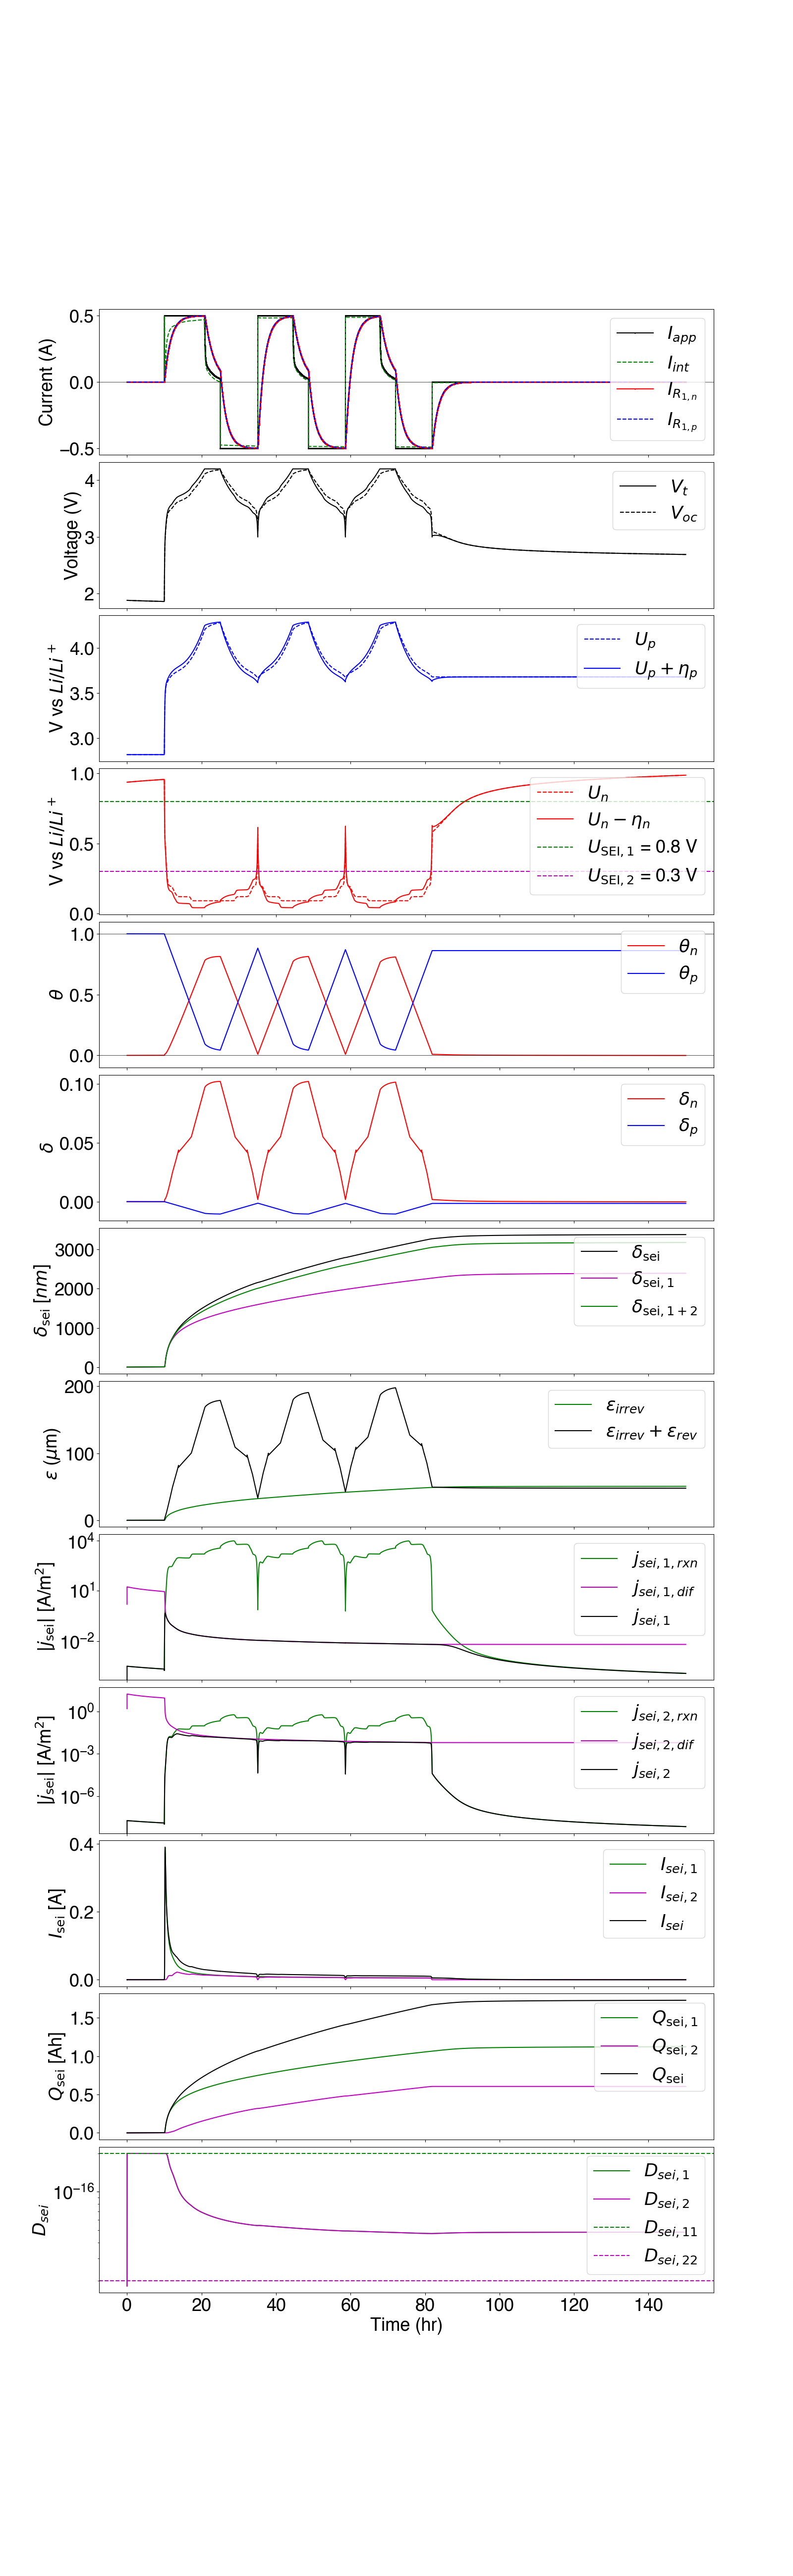

In [241]:
%autoreload
sim.plot()

In [242]:
df = pd.DataFrame(sim.__dict__)
df

,cell,dt,t,vmax,vmin,i_cv,i_app,cycle_number,step_number,theta_n,...,j_sei_dif2,eta_sei1,eta_sei2,delta_sei,delta_sei1,delta_sei2,delta_n,delta_p,expansion_rev,expansion_irrev
0,<src.cellsim.Cell object at 0x128fb8a90>,1.0,0.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000e+00,...,NaN,0.000000,0.000000,5.000000e-09,2.500000e-09,2.500000e-09,0.000000e+00,-0.000000,0.000000e+00,0.000000e+00
1,<src.cellsim.Cell object at 0x128fb8a90>,1.0,1.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000e+00,...,1.593236,0.136495,0.636495,5.000153e-09,2.500153e-09,2.500000e-09,0.000000e+00,-0.000000,0.000000e+00,7.500229e-08
2,<src.cellsim.Cell object at 0x128fb8a90>,1.0,2.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000e+00,...,17.515693,0.136495,0.636495,5.000306e-09,2.500306e-09,2.500000e-09,0.000000e+00,-0.000000,0.000000e+00,7.500458e-08
3,<src.cellsim.Cell object at 0x128fb8a90>,1.0,3.0,4.2,3.0,0.025,0.0,1.0,3.0,-1.195904e-08,...,17.515159,0.136495,0.636495,5.000458e-09,2.500458e-09,2.500000e-09,-2.391808e-09,-0.000000,-3.986355e-12,7.500687e-08
4,<src.cellsim.Cell object at 0x128fb8a90>,1.0,4.0,4.2,3.0,0.025,0.0,1.0,3.0,-2.392018e-08,...,17.514624,0.136496,0.636496,5.000611e-09,2.500611e-09,2.500000e-09,-4.784036e-09,-0.000000,-7.973410e-12,7.500917e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,<src.cellsim.Cell object at 0x128fb8a90>,1.0,539995.0,4.2,3.0,0.025,0.0,4.0,3.0,-8.708053e-04,...,0.006246,0.186586,0.686586,3.379035e-06,2.393766e-06,7.837815e-07,-1.741611e-04,-0.001519,-2.821711e-06,5.068552e-05
539996,<src.cellsim.Cell object at 0x128fb8a90>,1.0,539996.0,4.2,3.0,0.025,0.0,4.0,3.0,-8.708097e-04,...,0.006246,0.186586,0.686586,3.379035e-06,2.393766e-06,7.837815e-07,-1.741619e-04,-0.001519,-2.821713e-06,5.068552e-05
539997,<src.cellsim.Cell object at 0x128fb8a90>,1.0,539997.0,4.2,3.0,0.025,0.0,4.0,3.0,-8.708142e-04,...,0.006246,0.186586,0.686586,3.379035e-06,2.393766e-06,7.837815e-07,-1.741628e-04,-0.001519,-2.821714e-06,5.068552e-05
539998,<src.cellsim.Cell object at 0x128fb8a90>,1.0,539998.0,4.2,3.0,0.025,0.0,4.0,3.0,-8.708186e-04,...,0.006246,0.186587,0.686587,3.379035e-06,2.393766e-06,7.837815e-07,-1.741637e-04,-0.001519,-2.821715e-06,5.068552e-05


# Calculate cycle-by-cycle metrics

In [243]:
df = pd.DataFrame(sim.__dict__)
df['dq'] = np.abs(df['dt'] * df['i_app'] / 3600)
df_agg = df.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_agg

cycle_number  step_number
0.0           0.0            0.000000
1.0           0.0            5.390556
              1.0            0.350690
              2.0            5.035694
              3.0            0.000000
2.0           0.0            4.686944
              1.0            0.348727
              2.0            4.961528
3.0           0.0            4.613056
              1.0            0.348498
              2.0            4.912778
4.0           3.0            0.000000
Name: dq, dtype: float64

/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.manager.handle_json(content)


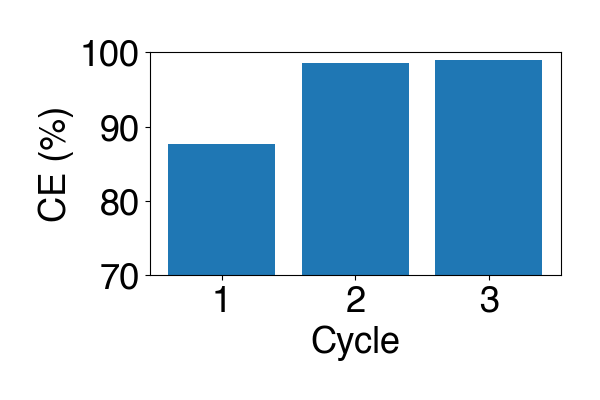

In [244]:
from matplotlib import pyplot as plt

ce = []
cycle_index = np.array([1, 2, 3])

for i in cycle_index:
    ce.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))

ce = np.array(ce)

plt.figure(figsize=(6, 4))
plt.bar(cycle_index, ce*100)
plt.ylabel('CE (%)')
plt.grid(False)
plt.xlabel('Cycle')
plt.ylim([70, 100])
plt.show()


Text(0, 0.5, '$U_n$')

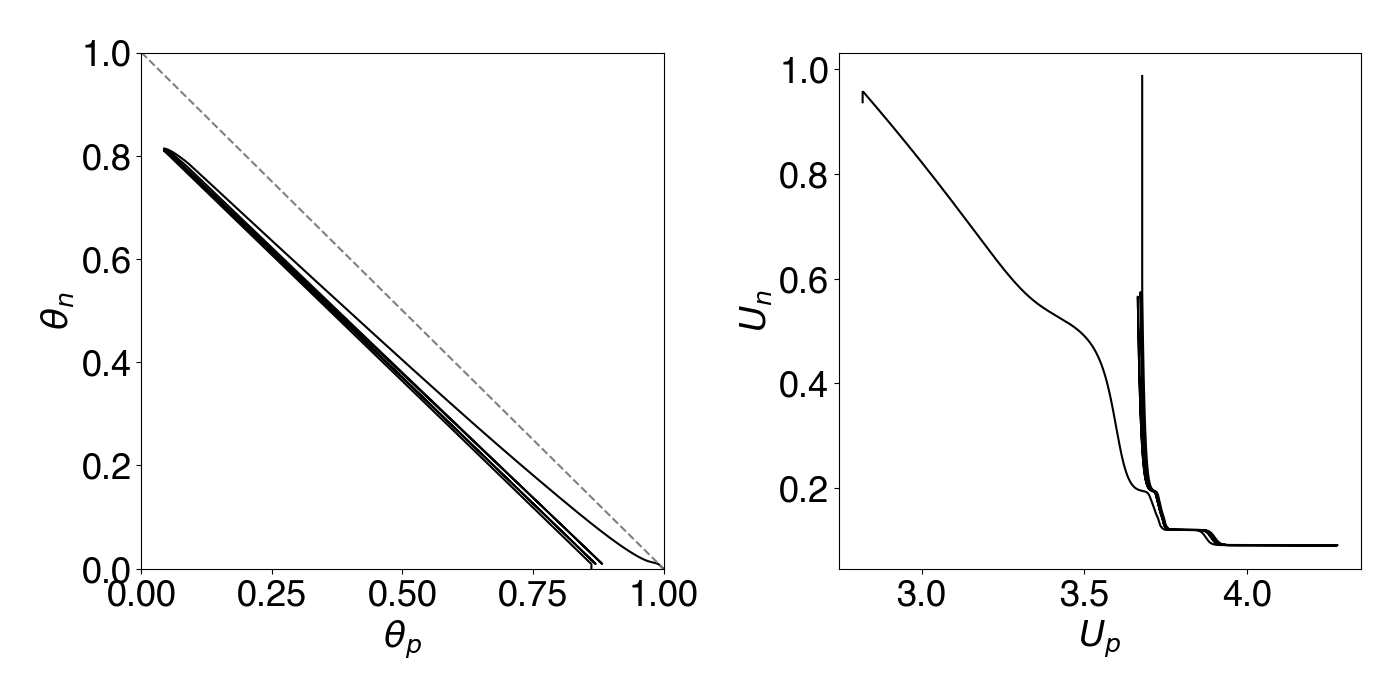

In [245]:
fh, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

xx = np.linspace(0, 1, 100)
ax0.plot(sim.theta_p, sim.theta_n, c='k')
ax0.plot(xx, 1-xx, c=(0.5,0.5,0.5), ls='--')
ax0.set_xlabel(r'$\theta_p$')
ax0.set_ylabel(r'$\theta_n$')
ax0.grid(False)
ax0.set_xlim((0,1))
ax0.set_ylim((0,1))

ax1.plot(sim.ocv_p, sim.ocv_n, c='k')
ax1.grid(False)
ax1.set_xlabel(r'$U_p$')
ax1.set_ylabel(r'$U_n$')